# Food Vision

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi -L
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

GPU 0: Tesla T4 (UUID: GPU-00ddb01c-2415-da34-a7a6-f166e6f38a0c)
--2025-11-15 05:30:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-11-15 05:30:37 (121 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Load the Dataset from Tensorflow Datasets

In [3]:
(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.U8A7Y7_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.U8A7Y7_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
len(train_data), len(test_data)

In [ ]:
print(f"Dataset info: {ds_info}")

In [6]:
class_names = ds_info.features['label'].names

In [7]:
sample = train_data.take(1)

Data Type of tensor <dtype: 'uint8'>
Data Shape of tensor (512, 512, 3)
Label 38 which means fish_and_chips


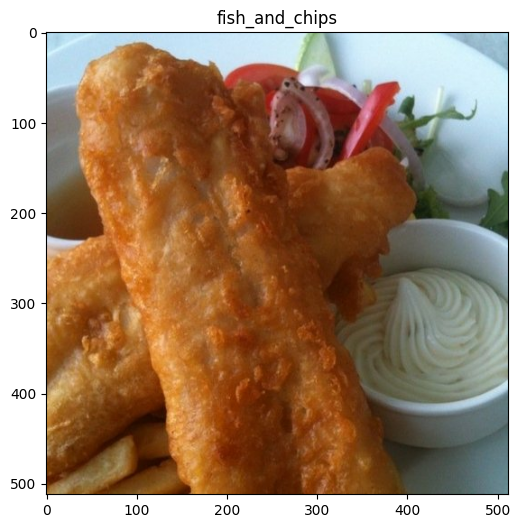

In [8]:
for a,b in sample:
  print(f'Data Type of tensor {a.dtype}')
  print(f'Data Shape of tensor {a.shape}')
  print(f'Label {b} which means {class_names[b]}')
  plt.figure(figsize=(6,6))
  plt.title(f'{class_names[b]}')
  plt.imshow(a)


## Pre-Process the Data

Currently we have tensors of **uint8** datatype. I plan on running mixed precision training, therefore we'd need **float16/32** bit tensors. They're also of various shapes, and non - normalised, which models tend to prefer. Let's fix this, while also implementing batching.

<dtype: 'float32'>
(224, 224, 3)


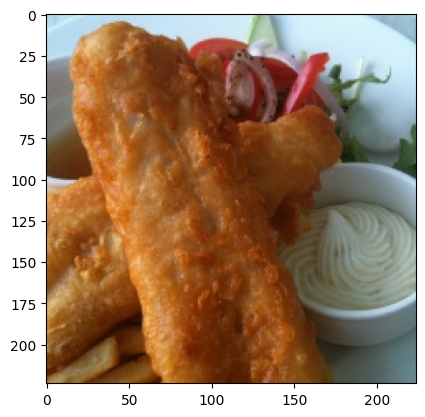

In [9]:
def pre_process_image(image,label, new_shape=[224,224]):
  image = tf.image.resize(image, new_shape)
  new_image = tf.cast(image, tf.float32)
  new_image = new_image/255.0
  return new_image, label
a,b = pre_process_image(a,b)
print(a.dtype)
print(a.shape)
plt.imshow(a)

In [10]:
# Batching the data, and then running shuffle again
train_data = train_data.map(map_func=pre_process_image, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle and prefetch, prefetching is getting the next segment of data to shuffle while you shuffle the current one
# the prefetching is on CPU, while map is on the GPU. the AUTOTUNE parrallel call enables parallelization
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=pre_process_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating some callbacks, in case we need to investigate further down the line

In [11]:
# Creating a Tensorboard Callback, just to log metrics during training such that we can look later on Tensorboard at them

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [12]:
# Model Checkpoint to save weights during training
checkpoint_path = 'checkpoint_path/cp.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,monitor='val_acc',
                                                      verbose=0,save_best_only=True,save_weights_only=True)

## Using Mixed Precision Training

In [13]:
# Using mixed precision training speeds up model training massively. By default, most tensor parameters are stored
# as 32 bit. By setting some such as activations, and CNN window weights as 16bit we can massively improve
# efficiency (hlaving our space). We still keep weights and biases as 32bit though
!nvidia-smi -L
# We're using Tesla T4 GPU. This has a compute capability of 7.5, we need 7 so we're all good to go

GPU 0: Tesla T4 (UUID: GPU-00ddb01c-2415-da34-a7a6-f166e6f38a0c)


In [14]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # making sure we've mixed 16 and 32 bit

## Build the Feature Extraction Model

In [15]:
#data augmentation - the benefit of incorporating it into the model is that it'll run on the gpu which is quicker

from tensorflow.keras import layers

data_aug = tf.keras.Sequential([layers.RandomFlip('vertical'),
                                layers.RandomHeight(0.2),
                                layers.RandomWidth(0.2),
                                layers.RandomRotation(0.2),
                                layers.RandomZoom(0.2)])

In [16]:
# We're gonna use EficcientNet B0 for this one
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

# Define input shape
input = layers.Input(shape=(224,224,3), name='input_layer')
input = data_aug(input)

#Instntiate Base Model
base = tf.keras.applications.EfficientNetB0(include_top=False)(input)
base.trainable= False

# Global Pooling 2D for a Feature Vector
pooling = layers.GlobalAveragePooling2D(name='pooling_layer')(base)

# Output
output = layers.Dense(len(class_names), activation='softmax', dtype = 'float32', name = 'output')(pooling)

# create the model and compile
model = tf.keras.Model(inputs=input, outputs=output)
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
for layer in model.layers: # just double checking
  print(f'Layer Name {layer.name}', end = ', ')
  print(f'Layer Type {layer.dtype}', end = ', ')
  print(f'Layer Policy {layer.dtype_policy}')
  print('---')
for layer in model.layers[1].layers:
  print(f'Layer Name {layer.name}', end = ', ')
  print(f'Layer Type {layer.dtype}', end = ', ')
  print(f'Layer Policy {layer.dtype_policy}')
  print('---')

Layer Name keras_tensor_7CLONE, Layer Type float16, Layer Policy <DTypePolicy "mixed_float16">
---
Layer Name efficientnetb0, Layer Type float32, Layer Policy <DTypePolicy "mixed_float16">
---
Layer Name pooling_layer, Layer Type float32, Layer Policy <DTypePolicy "mixed_float16">
---
Layer Name output, Layer Type float32, Layer Policy <DTypePolicy "float32">
---
Layer Name input_layer_1, Layer Type float32, Layer Policy <DTypePolicy "mixed_float16">
---
Layer Name rescaling, Layer Type float32, Layer Policy <DTypePolicy "mixed_float16">
---
Layer Name normalization, Layer Type float32, Layer Policy <DTypePolicy "mixed_float16">
---
Layer Name rescaling_1, Layer Type float32, Layer Policy <DTypePolicy "mixed_float16">
---
Layer Name stem_conv_pad, Layer Type float32, Layer Policy <DTypePolicy "mixed_float16">
---
Layer Name stem_conv, Layer Type float32, Layer Policy <DTypePolicy "mixed_float16">
---
Layer Name stem_bn, Layer Type float32, Layer Policy <DTypePolicy "mixed_float16">
---

In [ ]:
food_vision_history = model.fit(train_data, batch_size=32, epochs=5,
          callbacks=[model_checkpoint, create_tensorboard_callback('Food_Vision', 'Iteration_1')],
          steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(len(test_data)))


Saving TensorBoard log files to: Food_Vision/Iteration_1/20251115-054256
Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.4098 - loss: 2.4411

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_acc available.
  if self._should_save_model(epoch, batch, logs, filepath):


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 647s 186ms/step - accuracy: 0.4098 - loss: 2.4409 - val_accuracy: 0.0158 - val_loss: 4.7471
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 272s 114ms/step - accuracy: 0.6634 - loss: 1.2809 - val_accuracy: 0.0075 - val_loss: 6.8597
Epoch 3/5
1177/2368 ━━━━━━━━━━━━━━━━━━━━ 1:49 92ms/step - accuracy: 0.7223 - loss: 1.0227

## Evaluate Model on all Test Data

In [ ]:
model.evaluate(test_data) # Let's see how the model does on the entireity of the test data
# Also, lets save it before we fine tune it
model.save('Food_Vision_model_non_fine_tuned.keras')

## Fine Tuning by unfreezing EfficientNet Layers

In [ ]:
for layer in model.layers[1].layers:
  layer.trainable = True


In [ ]:
for layer in model.layers:
  print(f'layer trainabale  = {layer.trainable}')

In [ ]:
fine_tuned_food_vision_history = model.fit(train_data, batch_size=32, epochs=10, initial_epoch=5,
          callbacks=[model_checkpoint, create_tensorboard_callback('Food_Vision', 'Iteration_2')],
          steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15*len(test_data)))


## Evaluate fine tuned model

In [ ]:
model.evaluate(test_data)
model.save('fine_tuned_model')

## Visualise Results

In [ ]:
df_1 = pd.DataFrame(food_vision_history.history)
df_2 = pd.DataFrame(fine_tuned_food_vision_history.history)
total_history = pd.concat([df_1, df_2], axis=0).reset_index(drop=True)

# Plot accuracy and loss curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(total_history['accuracy'], label='Train Accuracy')
plt.plot(total_history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(total_history['loss'], label='Train Loss')
plt.plot(total_history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get test data predictions
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred_probs = model.predict(test_data, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Extra steps to help the model generalise better
These cells add more data augmentation, class weights, and a clearer training setup.

In [ ]:

# More data augmentation to help generalisation
# (kept simple and similar language)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug_generator = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_aug = aug_generator.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)


In [ ]:

# Class weights in case some foods appear more than others
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels=[]
for _, y in train_data:
    labels.extend(np.argmax(y,axis=1))

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: w for i, w in enumerate(class_weights)}
class_weights


In [ ]:

# A cleaner model fit using callbacks with comments explaining things simply
history_generalised = model.fit(
    train_data_aug,
    validation_data=test_data,
    epochs=20,
    callbacks=[reduce_lr],
    class_weight=class_weights
)
